## First data processing steps

In [1]:
import pandas as pd
#import geopandas as gpd
import json
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import base64
#pip install geopandas
#pip install spacy
#python -m spacy download en_core_web_lg

In [3]:
# read in the dataset 
df = pd.read_json('animal_news_database.json', lines = True)
# Read in the datasets defining our subset data

#undoc = pd.read_csv("undoc_species.csv", sep = ";")
charismatic = pd.read_csv("csv/charismatic_16.csv", sep = ";")
#edge = pd.read_csv("non_charismatic_20.csv", sep = ";")

In [4]:
charismatic = charismatic.rename(columns = {'Scientifc Name' : 'scientific_name'})
#charismatic = charismatic[['scientific_name', 'Ecosystem', 'Class']]
#edge = edge.rename(columns = {'Scientifc Name' : 'scientific_name'})
#edge = edge[['scientific_name', 'Ecosystem', 'Class', 'Conservation Attention']]

In [5]:
# Drop Twitter handles as they are not species names
df = df[df.scientific_name.str.contains('@') == False]
df.reset_index(drop = True, inplace = True)
# How many species listed total in this dataset
#df['scientific_name'].nunique()

# Add new column for storing the values article amount found under each species type 
df['article_amt'] = df['articles'].str.len()
    
## Good syntax to remember to find specific instances of a value in a specific column
#df.loc[df['scientific_name'].isin(['Perameles bougainville'])]

In [7]:
# Read in the CITES data to join with the top 10 (or 20) most reported on species 
cites1 = pd.read_csv("csv/cites1.csv", delimiter = ';')

# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Scientific Name', 'Listing', 'NativeDistributionFullNames', 'Extinct_Distribution']]

cites1 = cites1.rename(columns = {'Scientific Name' : 'scientific_name'})

# Do the same for the entire dataframe
df = df.merge(cites1, on = 'scientific_name', how = 'inner')


#df.head()
df = df.drop(['_id'], axis=1)

In [42]:
new_df = pd.read_csv("csv/articles-w-full_sharecount.csv", sep = ";")

In [38]:
df['Charisma'] = 0

# Loop through the species and create a binary classification for species that are charismatic or not
for x in df['scientific_name']:
    if x in list(charismatic['scientific_name']):
        df.loc[df['scientific_name'] == x, 'Charisma'] = 1

In [8]:
# Do the same for the entire dataframe
rizz = df.merge(charismatic, on = 'scientific_name', how = 'inner')
#dg = df.merge(edge, on = 'scientific_name', how = 'inner')

In [9]:
# Group dataframe by the scientific name that remains consistent for all rows 
rz_grouped = rizz.groupby('General ID name')# 'Class', 'iucn_status'])

# Calculate the totals of the group species
article_totals_rz = rz_grouped.article_amt.sum().round()

#article_totals_rz.nlargest(20)

# Group dataframe by the scientific name that remains consistent for all rows 
rz_grouped = rizz.groupby('scientific_name')# 'Class', 'iucn_status'])

# Calculate the totals of the group species
article_totals_rz = rz_grouped.article_amt.sum().round()

#article_totals_rz.nlargest(20)

General ID name
Whale         542
Bear          531
Crocodile     463
Rhinoceros    353
Dolphin       206
Gorilla       173
Elephant      151
Lion          138
Wolf          127
Tiger         102
Panther        95
Shark          53
Cheetah        52
Zebra          45
Chimpanzee     44
Panda          33
Name: article_amt, dtype: int64

In [10]:
# Explode the articles column
s = rizz['articles'].map(dict.values).explode()
# NaN values need to be droppped
s = s.dropna()
# Drop the column articles and join the exploded values to the dataframe
rizz_articles = rizz.drop(columns=['articles']).join(pd.DataFrame([*s], s.index))



# Processing for articles       
# keep only unique article instances
rizz_media = rizz_articles.drop_duplicates(subset=['text'])
# Transform date column into DateTime
rizz_media["date"] = rizz_media["date"].apply(pd.to_datetime)
# Sort by oldest to newest
rizz_media = rizz_media.sort_values(by="date")

In [12]:
rizz_media = rizz_media.drop(columns=['Unnamed: 8', 'article_amt'])
rizz_media.reset_index(drop = True, inplace = True)
rizz_media = rizz_media[rizz_media['text'].notna()]
#rizz_media.to_csv("full_rizz.csv", sep = ";", index = False)

In [13]:
# A new analysis of article amounts per species after text duplicates have been removed
rz_group = rizz_media.groupby('scientific_name')
totalz = rz_group.sum().round()
speciestop = totalz['Count'].nlargest(20)

rz_group = rizz_media.groupby('General ID name')
totalz = rz_group.sum().round()
general_IDtop = totalz['Count'].nlargest(20)

/tmp/ipykernel_44/1718699019.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  totalz = rz_group.sum().round()
/tmp/ipykernel_44/1718699019.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  totalz = rz_group.sum().round()


In [42]:
rizz_media['COUNTER'] =1       #initially, set that counter to 1.
group_data = rizz_media.groupby(['General ID name', 'Class_y','scientific_name'])['COUNTER'].sum() #sum function
test = group_data.nlargest(20).reset_index()

General ID name  Class_y  scientific_name         
Bear             Mammal   Helarctos malayanus          67
                          Melursus ursinus             35
                          Tremarctos ornatus           67
                          Ursus arctos                 66
                          Ursus arctos isabellinus     39
                                                     ... 
Whale            Mammal   Eubalaena japonica           19
                          Hyperoodon ampullatus        33
                          Physeter macrocephalus       26
Wolf             Mammal   Canis lupus                 124
Zebra            Mammal   Equus grevyi                 42
Name: COUNTER, Length: 64, dtype: int64


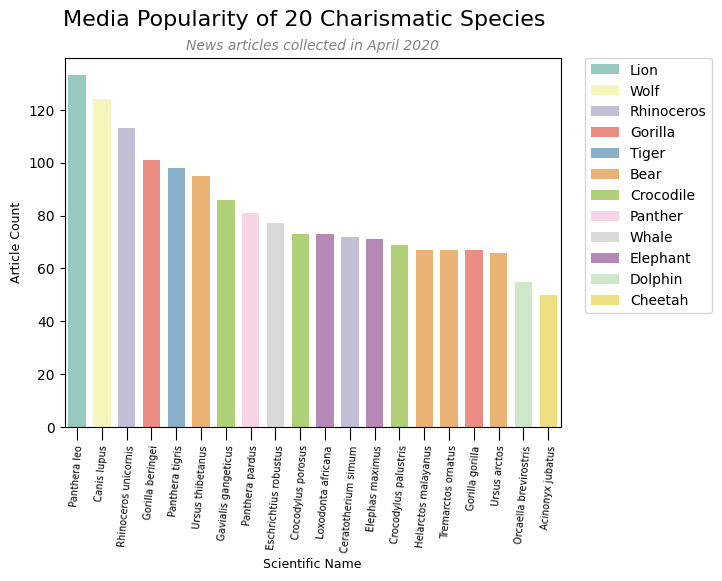

In [104]:
import seaborn as sns

ax = sns.barplot(
    x = 'scientific_name',
    y = 'COUNTER',
    hue = 'General ID name',
    data = test, 
    width = 0.7, palette = 'Set3', dodge = False
)
ax.set_xlabel('Scientific Name', fontsize=9)
ax.set_ylabel('Article Count', fontsize=9)


# Add suptitle above the title
plt.suptitle("Media Popularity of 20 Charismatic Species\n", fontsize=16)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('News articles collected in April 2020', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 7, left = True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('top_20_species.png', bbox_inches = 'tight')

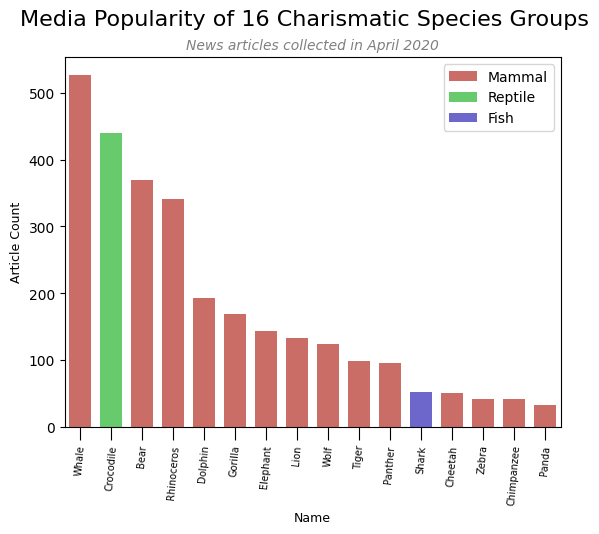

In [105]:
genid = rizz_media.groupby(['Class_y','General ID name'])['COUNTER'].sum() #sum function
genid = genid.nlargest(20).reset_index()

ax = sns.barplot(
    x = 'General ID name',
    y = 'COUNTER',
    hue = 'Class_y',
    data = genid, 
    width = 0.7, palette = 'hls', dodge = False
)
ax.set_xlabel('Name', fontsize=9)
ax.set_ylabel('Article Count', fontsize=9)


# Add suptitle above the title
plt.suptitle("Media Popularity of 16 Charismatic Species Groups\n", fontsize=16)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('News articles collected in April 2020', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 7, left = True)
ax.legend()#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0
plt.savefig('top_16_gen_species.png', bbox_inches = 'tight')

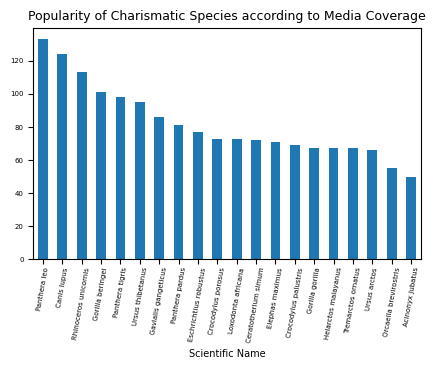

In [14]:
# What Charismatic species are given the most coverage?
# Create a simple bar graph displaying the amt of articles per species 
        
ax = speciestop.plot.bar(figsize = (5,3), fontsize = 5)
ax.set_xlabel('Scientific Name', fontsize=7)
ax.set_title('Popularity of Charismatic Species according to Media Coverage', fontsize = 9)
ax.tick_params(axis='x', rotation=80, left = True, pad = 2)
#plt.savefig('top_20_species.png', bbox_inches = 'tight')

## TEXT PROCESSING

In [14]:
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [16]:
import spacy 
import geonamescache
# pip install geonamescache
gc = geonamescache.GeonamesCache()

# gets nested dictionary for countries
countries = gc.get_countries()

# To avoid tensorflow warnings 
TF_CPP_MIN_LOG_LEVEL="2"
nlp = spacy.load('en_core_web_lg')

# Create a new column named 'processed_txt'
rizz_media['processed_txt'] = None

# Apply the language model under 'nlp' to the contents of the DataFrame column 'text'
rizz_media['processed_txt'] = rizz_media['text'].apply(nlp)

rizz_media.reset_index(drop=True, inplace=True)   

In [37]:
nltk.download('stopwords')
nltk.download('wordnet')
#Function retrieved from https://www.dataknowsall.com/textcleaning.html

def clean_string(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string



#rizz_media['text_clean'] = rizz_media['text'].apply(lambda x: clean_string(x, stem='Stem'))
rizz_media['title_clean_lem'] = rizz_media['title'].apply(lambda x: clean_string(x, stem='Lem'))
#rizz_media['title_clean_spcy'] = rizz_media['title'].apply(lambda x: clean_string(x, stem='Spacy'))

# Apply the language model under 'nlp' to the contents of the DataFrame column 'text'
#rizz_media['spacy'] = rizz_media['text_clean_spcy'].apply(nlp)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
# Obtained from https://stackoverflow.com/questions/59444065/differentiate-between-countries-and-cities-in-spacy-ner/59458133#59458133

def gen_dict_extract(var, key):
    if isinstance(var, dict):
        for k, v in var.items():
            if k == key:
                yield v
            if isinstance(v, (dict, list)):
                yield from gen_dict_extract(v, key)
    elif isinstance(var, list):
        for d in var:
            yield from gen_dict_extract(d, key)
            
countries = [*gen_dict_extract(countries, 'name')]   

In [20]:
# Define a function named 'get_ents' that takes a single object as input.
# We refer to this input using the variable name 'nlp_text'.
def get_ents(nlp_text, label):
    
    # First we make sure that the input is of correct type
    # by using the assert command to check the input type
    assert type(nlp_text) == spacy.tokens.doc.Doc
    
    # Let's set up a placeholder list for our ne's
    ents = []
    
    # We begin then begin looping over the Doc object
    for ent in nlp_text.ents:
        if (ent.label_ == label):
            if ent.text in countries:
                ents.append(ent.text) # Append the ent text to the list of ents to return
            
    # When the loop is complete, return the list of ents
    return ents

In [21]:
# Apply the 'get_ents' function to the column 'processed_txt'
#Create individual lists in order to store the values of different ents labels separately 
gpe_list = []
#org_list = []
#loc_list = []
#event_list = []
#norp_list = []

for i in rizz_media['processed_txt']:
    x = get_ents(i, "GPE")
    gpe_list.append(x)
    
    #y = get_ents(i, "ORG")
    #org_list.append(y)
    #z = get_ents(i, "LOC")
    #loc_list.append(z)
    #v = get_ents(i, "EVENT")
    #event_list.append(v)
    #w = get_ents(i, "NORP")
    #norp_list.append(w)

In [39]:
# Create a daatframe from the countries list 
gpe_df = pd.DataFrame({"Countries":gpe_list})
# Concatenate with the rizz media dataframe 
rz = pd.concat([rizz_media, gpe_df], axis = 1)

In [40]:
test1 = []

for x in rz['title_clean_lem']:
    items = x.split(' ')
    test1.append(items)
    
title_words = pd.DataFrame({"title_lems":test1})
t = pd.concat([rz, title_words], axis = 1)
t.head()   

,common_name,scientific_name,distribution,iucn_status,date_saved,Kingdom,Class_x,Order,Family,Genus,...,title,link,image,date,ner,processed_txt,title_clean_spcy,title_clean_lem,Countries,title_lems
0,Javan Rhinoceros,Rhinoceros sondaicus,"Bangladesh, Cambodia, China, India, Indonesia,...",Critically Endangered,2020-06-18,Animalia,Mammalia,Perissodactyla,Rhinocerotidae,Rhinoceros,...,Sumatran Rhino Population Critical,https://news.google.com/articles/CBMiQmh0dHBzO...,https://statik.tempo.co/data/2015/02/09/id_369...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Indonesia is ho...","(TEMPO.CO, ,, Jakarta, -, Indonesia, is, home,...",sumatran rhino population critical,sumatran rhino population critical,[Indonesia],"[sumatran, rhino, population, critical]"
1,Javan Rhinoceros,Rhinoceros sondaicus,"Bangladesh, Cambodia, China, India, Indonesia,...",Critically Endangered,2020-06-18,Animalia,Mammalia,Perissodactyla,Rhinocerotidae,Rhinoceros,...,Javan Rhinos to be Transferred to Cikepuh Wild...,https://news.google.com/articles/CBMiWmh0dHBzO...,https://statik.tempo.co/data/2011/12/29/id_100...,1970-01-01,"[{'sent': 'TEMPO.CO, Jakarta - Director of the...","(TEMPO.CO, ,, Jakarta, -, Director, of, the, B...",javan rhino transfer cikepuh wildlife reserve,javan rhino transferred cikepuh wildlife reserve,[],"[javan, rhino, transferred, cikepuh, wildlife,..."
2,Grevy's Zebra,Equus grevyi,"Djibouti, Ethiopia, Kenya, Somalia, South Sudan",EN,2020-06-18,Animalia,Mammalia,Perissodactyla,Equidae,Equus,...,California zoo welcomes Grevy’s zebra colt foal,https://news.google.com/articles/CBMiSGh0dHBzO...,https://i1.wp.com/www.horsetalk.co.nz/wp-conte...,2001-11-30,"[{'sent': 'A Grevy’s', 'ents': {'ORG': ['Grevy...","(Share, \n\n\n\n\n\n\n\n\n\n\n\n, A, Grevy, ’s...",california zoo welcome grevy ’s zebra colt foal,california zoo welcome grevy’s zebra colt foal,[],"[california, zoo, welcome, grevy’s, zebra, col..."
3,Tucuxi,Sotalia fluviatilis,"Brazil, Colombia, Costa Rica, Ecuador, Nicarag...",Data Deficient,2020-06-18,Animalia,Mammalia,Cetacea,Delphinidae,Sotalia,...,Why dolphins are deep thinkers,https://news.google.com/articles/CBMiQGh0dHBzO...,https://i.guim.co.uk/img/static/sys-images/Env...,2003-07-03,[{'sent': 'At the Institute for Marine Mammal ...,"(At, the, Institute, for, Marine, Mammal, Stud...",dolphin deep thinker,dolphin deep thinker,"[Brazil, Australia]","[dolphin, deep, thinker]"
4,Western Gorilla,Gorilla gorilla,"Angola, Cameroon, Central African Republic, Co...",CR,2020-06-18,Animalia,Mammalia,Primates,Hominidae,Gorilla,...,Gorilla study gives social clues,https://news.google.com/articles/CBMiNWh0dHA6L...,http://newsimg.bbc.co.uk/media/images/39953000...,2004-03-23,"[{'sent': 'By Helen Briggs ', 'ents': {'PERSO...","(By, Helen, Briggs, \n\n, BBC, News, Online, s...",gorilla study give social clue,gorilla study give social clue,"[Central African Republic, Germany, Germany]","[gorilla, study, give, social, clue]"


In [65]:
# Saving top 500 words to create topics out of 
title_wrds = t.explode('title_lems')['title_lems'].value_counts().nlargest(500)
title_wrds.to_csv("title_lems.csv")

In [149]:
# Explode the lists in the Countries column so each species has one row dedicated per country
s = rz.explode('Countries').groupby(['scientific_name'])['Countries'].value_counts()
# create csv
s.to_csv("Countries_inarticles_count.csv", sep = ';')

# read in newly created dataframe 
country_count = pd.read_csv("Countries_inarticles_count.csv", sep = ';')
# Transform earlier defined variable of top 20 covered species into dataframe
x = speciestop.to_frame()
# Merge on scientific_name column
top20_GPE = country_count.merge(x, on = 'scientific_name', how = 'inner')
# rename columns for more intiuitve naming system 
top20_GPE = top20_GPE.rename(columns = {'Countries.1' : 'Country_count', 'Count' : 'article_count'})
# Save to csv for geocoding in other notebook
top20_GPE.to_csv("20species_GPEtags.csv", sep = ';', index = False)

In [23]:
def list_to_graph(name):

    # Set up the placeholder list
    final_list = []

    # Loop over each list in the list of lists
    for nlist in name:
    
        # Extend the final list with the current list
        final_list.extend(nlist)
    
    # Convert the list into a pandas Series, count unique nouns
    # using the value_counts() method, get the 10 most frequent
    # items [:10] and plot the result into a bar chart using the
    # plot() method and its attribute 'kind'.
    return pd.Series(final_list).value_counts()[:15].plot(kind='bar')

# General Visualizations to Return to

In [44]:
# Explode the articles column
s = df['articles'].map(dict.values).explode()
# NaN values need to be droppped
s = s.dropna()
# Drop the column articles and join the exploded values to the dataframe
df_full = df.drop(columns=['articles']).join(pd.DataFrame([*s], s.index))



# Processing for articles       
# keep only unique article instances
df_media = df_full.drop_duplicates(subset=['text'])
# Transform date column into DateTime
df_media["date"] = df_media["date"].apply(pd.to_datetime)
# Sort by oldest to newest
df_media = df_media.sort_values(by="date")
# Drop article amt column, unneccessary 
df_media = df_media.drop(columns=['article_amt'])
# reset index
df_media.reset_index(drop = True, inplace = True)
# Remove any rows with blank data for the text column
df_media = df_media[df_media['text'].notna()]

/tmp/ipykernel_96/2932848630.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_media["date"] = df_media["date"].apply(pd.to_datetime)


### Testing Impact of Charisma

In [97]:
df_media['COUNTER'] =1       #initially, set that counter to 1.
group_data = df_media.groupby(['scientific_name', 'Class', 'Charisma'])['COUNTER'].sum() #sum function
test = group_data.reset_index()

In [140]:
#df_media['COUNTER'] =1       #initially, set that counter to 1.
group_data = df_media.groupby(['Charisma', 'scientific_name'])['COUNTER'].sum() #sum function
test_c = group_data.reset_index()

In [145]:
bland = test_c.loc[test_c['Charisma'] == 0].sample(n = 64)
rizz = test_c.loc[test_c['Charisma'] == 1]

In [147]:
sample = pd.concat([bland, rizz])

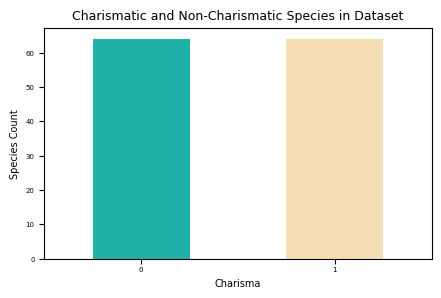

In [148]:
#df['COUNTER'] =1       #initially, set that counter to 1.
grouped = sample.groupby(['Charisma']) 
# Calculate the totals of the group species
charisma = grouped.scientific_name.nunique()


ax = charisma.plot.bar(figsize = (5,3), fontsize = 5, color = ['lightseagreen', 'wheat'])
ax.set_xlabel('Charisma', fontsize=7)
ax.set_ylabel('Species Count', fontsize=7)
ax.set_title('Charismatic and Non-Charismatic Species in Dataset', fontsize = 9)
ax.tick_params(axis='x', rotation=0, left = True, pad = 2)

In [102]:
test['Mammal'] = 0

for x in test['Class']:
    if x == 'Mammalia':
        test.loc[test['Class'] == x, 'Mammal'] = 1


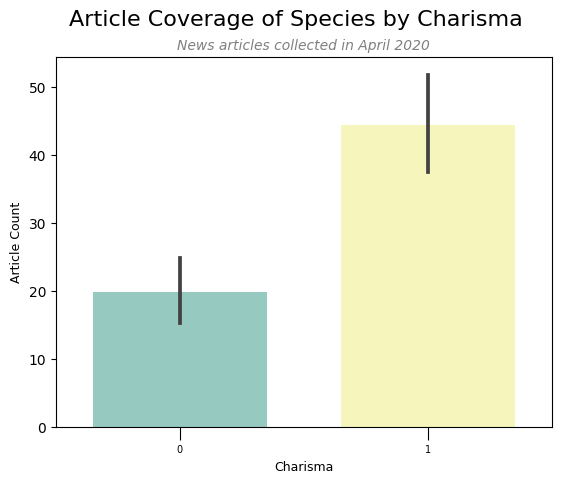

In [149]:
import seaborn as sns

ax = sns.barplot(
    x = 'Charisma',
    y = 'COUNTER',
    #hue = 'Charisma',
    data = sample, 
    width = 0.7, palette = 'Set3'
    #dodge = False
)
ax.set_xlabel('Charisma', fontsize=9)
ax.set_ylabel('Article Count', fontsize=9)


# Add suptitle above the title
plt.suptitle("Article Coverage of Species by Charisma\n", fontsize=16)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('News articles collected in April 2020', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=0, length = 9, labelsize = 7, left = True)
#legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#legend.set_title("Charismatic")
#for t, l in zip(legend.texts,("No", "Yes")):
    #t.set_text(l)
#plt.savefig('figures/rizz_article_total.png', bbox_inches = 'tight')

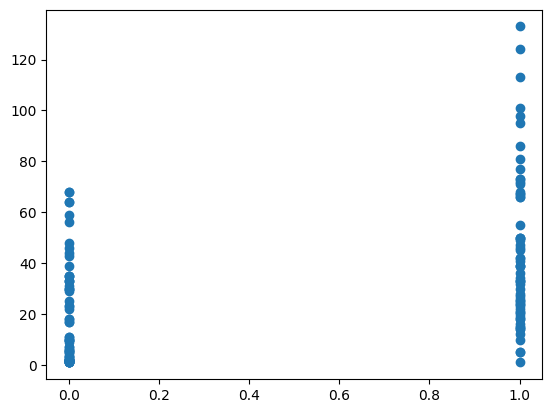

In [152]:
plt.scatter(sample['Charisma'], sample['COUNTER'])
plt.show()

In [150]:
sample

,Charisma,scientific_name,COUNTER
79,0,Brachylophus vitiensis,11
109,0,Catreus wallichii,17
97,0,Capra falconeri,48
259,0,Lophura edwardsi,4
475,0,Trachypithecus geei,30
...,...,...,...
560,1,Sousa teuszii,10
561,1,Tremarctos ornatus,67
562,1,Ursus arctos,66
563,1,Ursus arctos isabellinus,39


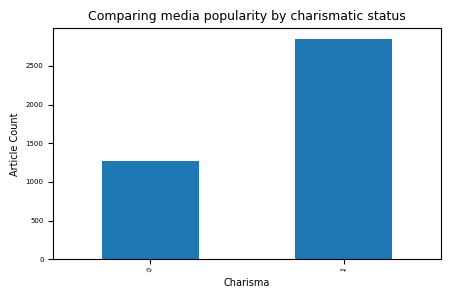

In [153]:
# A new analysis of article amounts per species after text duplicates have been removed
totalz = sample.groupby('Charisma').sum('COUNTER').round()
#totalz = rz_group.sum().round()
#speciestop = totalz['Count'].nlargest(20)
ax = totalz['COUNTER'].plot.bar(figsize = (5,3), fontsize = 5)
ax.set_xlabel('Charisma', fontsize=7)
ax.set_ylabel('Article Count', fontsize=7)
ax.set_title('Comparing media popularity by charismatic status', fontsize = 9)
ax.tick_params(axis='x', rotation=80, left = True, pad = 2)

In [154]:
from scipy.stats import spearmanr

#calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(sample['Charisma'], sample['COUNTER'])

#print Spearman rank correlation and p-value
print(rho)
print(p)

0.4615667140988347
4.166722739064949e-08


In [10]:
# Whole dataset articles
read = pd.DataFrame()

for i in df.articles:
    for x in i.values():
        nd = pd.DataFrame.from_dict(x)
        read = pd.concat([read, nd])

# keep only unique article instances
read = read.drop_duplicates(subset=['text'])

# Transform date column into DateTime
read["date"] = pd.to_datetime(read["date"])
# Sort by oldest to newest
read = read.sort_values(by="date")

read.head()

KeyboardInterrupt: 

<AxesSubplot:xlabel='date'>

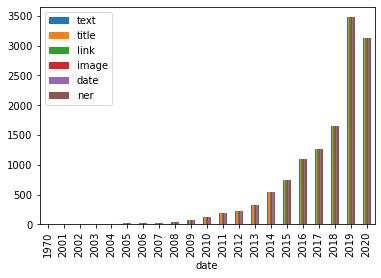

In [20]:
# Create a quick visualization of the date distribution 
read.groupby(read["date"].dt.year).count().plot(kind="bar")

In [17]:
# Simplify the IUCN categories

df["iucn_status"].replace({"Least Concern": "LC", "Lower Risk/least concern": "LC", 
                                "Vulnerable" : "VU", "Near Threatened" : "NT", "Critically Endangered" : "CR",
                          "Extinct in the Wild" : "EW", "Endangered" : "EN", "Data Deficient" : "DD", 
                          "Extinct" : "EX"}, inplace=True)

df['iucn_status'].unique()

## DROP NA
df_mod = df[ (df['iucn_status'] != 'NA') & (df['iucn_status'] != ' Brede & Rödel')]
df_mod
#df.drop(df.loc[df['iucn_status'].isin(['NA'])])
#df.loc[df['scientific_name'].isin(['Perameles bougainville'])]

/tmp/ipykernel_93/1468945897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["iucn_status"].replace({"Least Concern": "LC", "Lower Risk/least concern": "LC",


array(['CR', 'LC', 'NT', 'NA', 'EW', 'VU', 'EN', 'DD', 'EX',
       'Lower Risk/conservation dependent', ' Brede & Rödel'],
      dtype=object)

In [19]:
# Assigning each category a more relevant color
cmap = {'CR': 'red', 'EN': 'orange', 'VU': 'yellow', 'NT': 'green', 'LC': 'blue'}
colors = ['#2059BA','#FAE666','#A90A0A','#F9820B', '#128A16']

Text(0.5, 1.0, 'IUCN Status Share of Dataset')

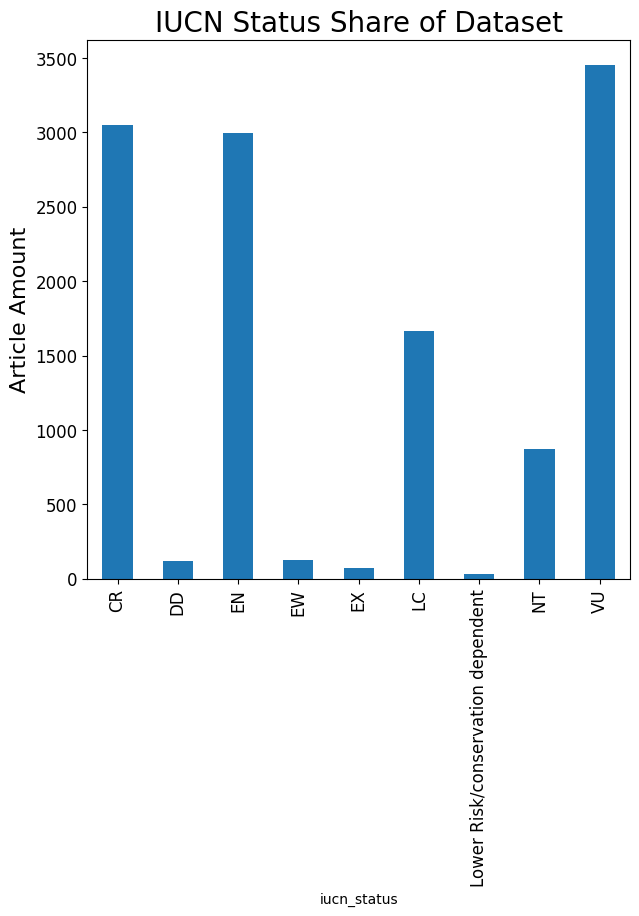

In [40]:
# Group dataframe by the scientific name that remains consistent for all rows 
grouped_i = df_mod.groupby('iucn_status')

# Calculate the totals of the group species
article_totals_i = grouped_i.article_amt.sum().round()


# What species are being reported on the most? 
# Create a simple bar graph displaying the amt of articles per species 
ax = article_totals_i.plot.bar(cmap, figsize = (7,7), 
                                                fontsize = 12)
ax.set_ylabel('Article Amount', fontsize=16)
ax.set_title('IUCN Status Share of Dataset', fontsize = 20)
#plt.savefig('IUCN-share.png', bbox_inches = 'tight')

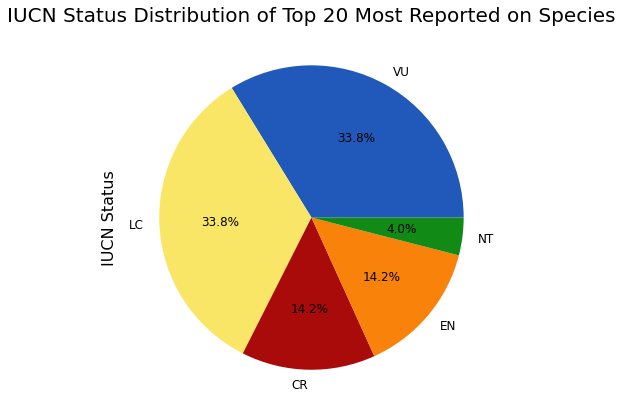

In [27]:
# Defining parameters for pie chart of IUCN Status
ax = top_twen['iucn_status'].value_counts().plot(kind = 'pie', autopct="%1.1f%%", figsize = (7,7), 
                                                fontsize = 12, colors = colors)

ax.set_ylabel('IUCN Status', fontsize=16)
ax.set_title('IUCN Status Distribution of Top 20 Most Reported on Species', fontsize = 20)
plt.savefig('IUCN-status.png', bbox_inches = 'tight')

In [32]:
# A quick look at the species' distribution
g = top_twen['article_amt'].groupby(top_twen['scientific_name'])



In [90]:
# Create a simplified version of the dataframe
smplfd = top_twen[['scientific_name', 'distribution', 'iucn_status']]
smplfd.drop_duplicates(inplace = True)
smplfd.reset_index(drop = True, inplace = True)
# Conduct merges of the dataframes
smplfd.merge(cites1, on = 'scientific_name', how = 'inner')
smplfd

In [35]:
# Do the same for the entire dataframe
df = df.merge(cites1, on = 'scientific_name', how = 'inner')

In [42]:
# Group dataframe by the Kingdom that remains consistent for all rows 
grouped_k = df.groupby('Kingdom')

# Calculate the totals of the group Kingdom
article_totals_k = grouped_k.article_amt.sum().round()

In [43]:
article_totals_k

Kingdom
Animalia    13390.0
Plantae       175.0
Name: article_amt, dtype: float64

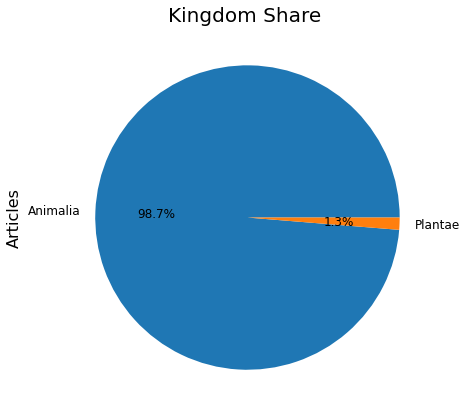

In [59]:
# What Kingdom is being reported on the most? 
# Create a simple pie chart displaying the amt of articles per Kingdom
ax = article_totals_k.plot.pie(y = 'Kingdom', autopct="%1.1f%%", figsize = (7,7), fontsize = 12)
ax.set_ylabel('Articles', labelpad = 35, fontsize=16)
ax.set_title('Kingdom Share ', fontsize = 20)
plt.savefig('Kingdom-Share.png', bbox_inches = 'tight')


In [73]:
df['Class'].value_counts()

Mammalia          1220
Aves               498
Reptilia           338
Actinopteri         46
Amphibia            30
Elasmobranchii      24
Bivalvia            24
Coelacanthi          9
Insecta              8
Name: Class, dtype: int64

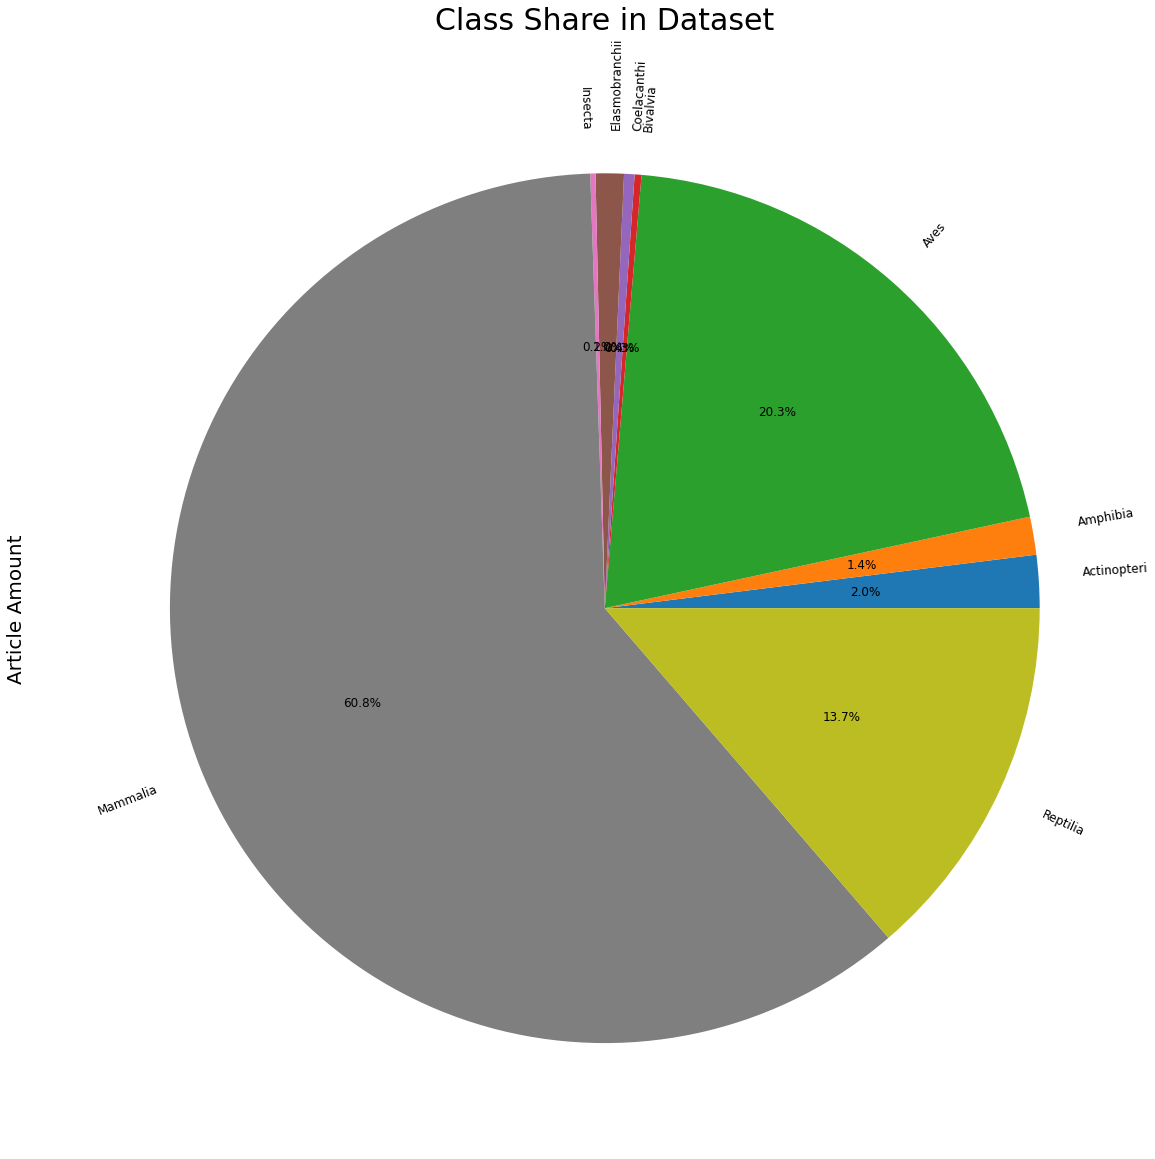

In [70]:
# Group dataframe by the Class that remains consistent for all rows 
grouped_c = df.groupby('Class')

# Calculate the totals of the Classes
article_totals_c = grouped_c.article_amt.sum().round()


# What Class is being reported on the most? 
# Create a simple pie graph displaying the amt of articles per species 
ax = article_totals_c.plot.bar(figsize = (20,20), autopct="%1.1f%%", fontsize = 12, rotatelabels=True)

ax.set_ylabel('Article Amount', labelpad = 35, fontsize=20)
ax.set_title('Class Share in Dataset', pad = 35, fontsize = 30)
plt.savefig('class-share.png', bbox_inches = 'tight')

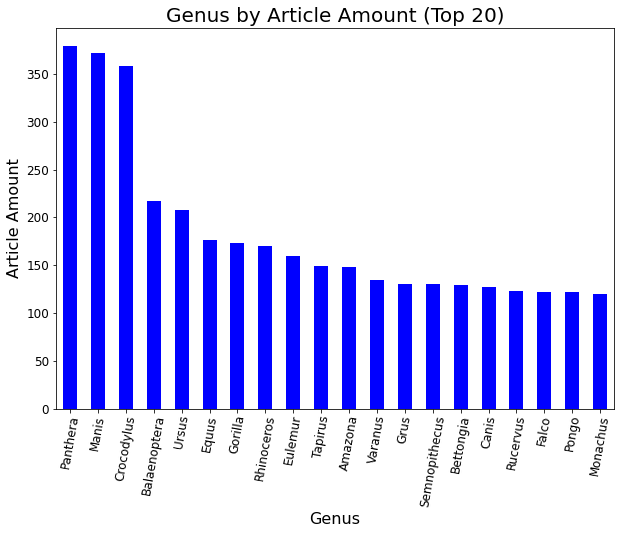

In [78]:
# Group dataframe by the scientific name that remains consistent for all rows 
grouped_G = df.groupby('Genus')

# Calculate the totals of the group species
article_totals_G = grouped_G.article_amt.sum().round()


# What species are being reported on the most? 
# Create a simple bar graph displaying the amt of articles per species 
ax = article_totals_G.nlargest(20).plot.bar(color = 'blue', figsize = (10,7), fontsize = 12)
ax.set_xlabel('Genus', fontsize=16)
ax.set_ylabel('Article Amount', fontsize = 16)
ax.set_title('Genus by Article Amount (Top 20)', fontsize = 20)
ax.tick_params(axis='x', rotation=80, left = True, pad = 2)
plt.savefig('top_20_genus.png', bbox_inches = 'tight')

13/04/22

Next visualization step:
- Don't just visualize the dataset, look at the corresponding articles published for that class! for that genus! SO need to do groupby functions 